In [1]:
import pandas as pd
df = pd.read_csv('Downloads/MFTD.csv')

In [2]:
# from sklearn.datasets import fetch_20newsgroups
# data = fetch_20newsgroups(subset='all')['data']
data = df['content'].to_list()

In [3]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distiluse-base-multilingual-cased-v2')
embeddings = model.encode(data, show_progress_bar=True)

Batches:   0%|          | 0/80 [00:00<?, ?it/s]

In [4]:
embeddings

array([[-0.01613348,  0.0375042 ,  0.02176371, ..., -0.01265028,
        -0.01246515,  0.0492409 ],
       [-0.00736774,  0.03207538, -0.00852449, ..., -0.01920373,
         0.00057049,  0.0325732 ],
       [ 0.02595449,  0.06451923,  0.03764753, ..., -0.01863546,
        -0.0129429 ,  0.03019698],
       ...,
       [ 0.00750094,  0.05176154,  0.05252821, ..., -0.0464084 ,
         0.03267388,  0.07290251],
       [-0.00578924,  0.02302632,  0.00010989, ...,  0.00241636,
         0.00731329,  0.00899413],
       [-0.04199426, -0.00576079,  0.06531923, ..., -0.05987998,
         0.05268479, -0.01763881]], dtype=float32)

In [5]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=10, 
                            n_components=10,
                            metric='cosine').fit_transform(embeddings)

In [6]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=5,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

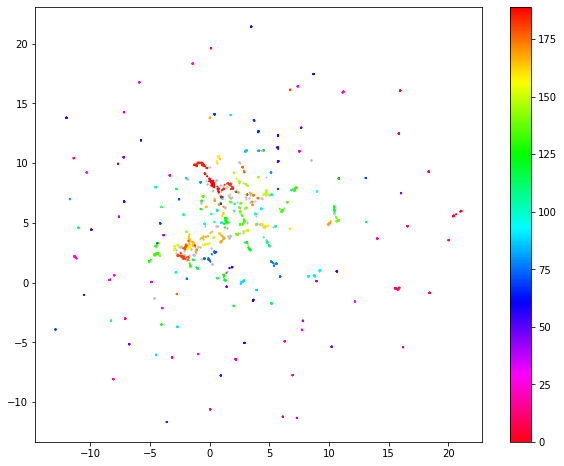

In [9]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=5, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(10, 8))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=1)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=1, cmap='hsv_r')
plt.colorbar()

In [10]:
import numpy as np
np.unique(cluster.labels_)

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 17

In [11]:
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [12]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

In [13]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,298
186,185,60
190,189,53
159,158,36
90,89,35
131,130,35
132,131,33
24,23,33
140,139,30
13,12,29


In [17]:
top_n_words[57][:10]

[('billy', 0.043797173932390326),
 ('bruse', 0.03251112264379325),
 ('gruff', 0.031951571686037926),
 ('bukken', 0.03022009734895852),
 ('tripp', 0.02889877568337178),
 ('trapp', 0.02840139705425593),
 ('trip', 0.027947325941459433),
 ('bridge', 0.026304750716027264),
 ('goat', 0.024764720644094265),
 ('werrel', 0.02367339927237616)]

In [80]:
from sklearn.metrics.pairwise import cosine_similarity
for i in range(20):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(data)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,290
82,81,72
170,169,63
10,9,47
134,133,36
123,122,35
74,73,35
8,7,33
107,106,32
153,152,32


In [81]:
topic_sizes

,Topic,Size
0,-1,290
82,81,72
170,169,63
10,9,47
134,133,36
...,...,...
140,139,7
28,27,7
129,128,7
1,0,7


In [82]:
from cleanlab.pruning import get_noise_indices

ordered_label_errors = get_noise_indices(
    s=numpy_array_of_noisy_labels,
    psx=numpy_array_of_predicted_probabilities,
    sorted_index_method='normalized_margin', # Orders label errors
 )

NameError: name 'numpy_array_of_noisy_labels' is not defined

In [83]:
from sentence_transformers import SentenceTransformer, SentencesDataset, InputExample, losses

model = SentenceTransformer('distilbert-base-nli-mean-tokens')
train_examples = [
    InputExample(texts=['My first sentence', 'My second sentence'], label=0.8),
    InputExample(texts=['Another pair', 'Unrelated sentence'], label=0.3)
]

train_dataset = SentencesDataset(train_examples, model)

In [88]:
train_dataset.examples[0].label

0.8

In [102]:
from torch.utils.data import DataLoader
import math
from sentence_transformers import SentenceTransformer,  LoggingHandler, losses, models, util
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.readers import InputExample
import logging
from datetime import datetime
import sys
import os
import gzip
import csv

#### Just some code to print debug information to stdout
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])
#### /print debug information to stdout



#Check if dataset exsist. If not, download and extract  it
sts_dataset_path = 'datasets/stsbenchmark.tsv.gz'

if not os.path.exists(sts_dataset_path):
    util.http_get('https://sbert.net/datasets/stsbenchmark.tsv.gz', sts_dataset_path)



#You can specify any huggingface/transformers pre-trained model here, for example, bert-base-uncased, roberta-base, xlm-roberta-base
model_name = 'distilbert-base-uncased'

# Read the dataset
train_batch_size = 16
num_epochs = 4
model_save_path = 'output/training_stsbenchmark_'+model_name.replace("/", "-")+'-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Use Huggingface/transformers model (like BERT, RoBERTa, XLNet, XLM-R) for mapping tokens to embeddings
word_embedding_model = models.Transformer(model_name)

# Apply mean pooling to get one fixed sized sentence vector
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                               pooling_mode_mean_tokens=True,
                               pooling_mode_cls_token=False,
                               pooling_mode_max_tokens=False)

model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

# Convert the dataset to a DataLoader ready for training
logging.info("Read STSbenchmark train dataset")

train_samples = []
dev_samples = []
test_samples = []
with gzip.open(sts_dataset_path, 'rt', encoding='utf8') as fIn:
    reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in reader:
        score = float(row['score']) / 5.0  # Normalize score to range 0 ... 1
        inp_example = InputExample(texts=[row['sentence1'], row['sentence2']], label=score)

        if row['split'] == 'dev':
            dev_samples.append(inp_example)
        elif row['split'] == 'test':
            test_samples.append(inp_example)
        else:
            train_samples.append(inp_example)


train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)
train_loss = losses.CosineSimilarityLoss(model=model)


logging.info("Read STSbenchmark dev dataset")
evaluator = EmbeddingSimilarityEvaluator.from_input_examples(dev_samples, name='sts-dev')


# Configure the training. We skip evaluation in this example
warmup_steps = math.ceil(len(train_dataloader) * num_epochs  * 0.1) #10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))


# Train the model
model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=num_epochs,
          evaluation_steps=1000,
          warmup_steps=warmup_steps,
          output_path=model_save_path)


##############################################################################
#
# Load the stored model and evaluate its performance on STS benchmark dataset
#
##############################################################################

model = SentenceTransformer(model_save_path)
test_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(test_samples, name='sts-test')
test_evaluator(model, output_path=model_save_path)

2021-05-16 18:28:05 - Lock 140464960832176 acquired on /home/anthony/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.d423bdf2f58dc8b77d5f5d18028d7ae4a72dcfd8f468e81fe979ada957a8c361.lock


Downloading:   0%|          | 0.00/442 [00:00<?, ?B/s]

2021-05-16 18:28:06 - Lock 140464960832176 released on /home/anthony/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.d423bdf2f58dc8b77d5f5d18028d7ae4a72dcfd8f468e81fe979ada957a8c361.lock
2021-05-16 18:28:06 - Lock 140460726372432 acquired on /home/anthony/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a.lock


Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

2021-05-16 18:28:14 - Lock 140460726372432 released on /home/anthony/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a.lock


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


2021-05-16 18:28:15 - Lock 140464960759504 acquired on /home/anthony/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

2021-05-16 18:28:16 - Lock 140464960759504 released on /home/anthony/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock
2021-05-16 18:28:16 - Lock 140460722916272 acquired on /home/anthony/.cache/huggingface/transformers/75abb59d7a06f4f640158a9bfcde005264e59e8d566781ab1415b139d2e4c603.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4.lock


Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

2021-05-16 18:28:17 - Lock 140460722916272 released on /home/anthony/.cache/huggingface/transformers/75abb59d7a06f4f640158a9bfcde005264e59e8d566781ab1415b139d2e4c603.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4.lock
2021-05-16 18:28:18 - Lock 140460722916272 acquired on /home/anthony/.cache/huggingface/transformers/8c8624b8ac8aa99c60c912161f8332de003484428c47906d7ff7eb7f73eecdbb.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79.lock


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

2021-05-16 18:28:18 - Lock 140460722916272 released on /home/anthony/.cache/huggingface/transformers/8c8624b8ac8aa99c60c912161f8332de003484428c47906d7ff7eb7f73eecdbb.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79.lock
2021-05-16 18:28:18 - Use pytorch device: cuda
2021-05-16 18:28:18 - Read STSbenchmark train dataset
2021-05-16 18:28:19 - Read STSbenchmark dev dataset
2021-05-16 18:28:19 - Warmup-steps: 144


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

2021-05-16 18:28:44 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset after epoch 0:
2021-05-16 18:28:45 - Cosine-Similarity :	Pearson: 0.8618	Spearman: 0.8603
2021-05-16 18:28:45 - Manhattan-Distance:	Pearson: 0.8238	Spearman: 0.8289
2021-05-16 18:28:45 - Euclidean-Distance:	Pearson: 0.8244	Spearman: 0.8294
2021-05-16 18:28:45 - Dot-Product-Similarity:	Pearson: 0.7996	Spearman: 0.8050
2021-05-16 18:28:45 - Save model to output/training_stsbenchmark_distilbert-base-uncased-2021-05-16_18-28-05


Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

2021-05-16 18:29:11 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset after epoch 1:
2021-05-16 18:29:12 - Cosine-Similarity :	Pearson: 0.8707	Spearman: 0.8693
2021-05-16 18:29:12 - Manhattan-Distance:	Pearson: 0.8325	Spearman: 0.8380
2021-05-16 18:29:12 - Euclidean-Distance:	Pearson: 0.8329	Spearman: 0.8386
2021-05-16 18:29:12 - Dot-Product-Similarity:	Pearson: 0.8066	Spearman: 0.8124
2021-05-16 18:29:12 - Save model to output/training_stsbenchmark_distilbert-base-uncased-2021-05-16_18-28-05


Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

2021-05-16 18:29:39 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset after epoch 2:
2021-05-16 18:29:40 - Cosine-Similarity :	Pearson: 0.8715	Spearman: 0.8695
2021-05-16 18:29:40 - Manhattan-Distance:	Pearson: 0.8337	Spearman: 0.8383
2021-05-16 18:29:40 - Euclidean-Distance:	Pearson: 0.8341	Spearman: 0.8390
2021-05-16 18:29:40 - Dot-Product-Similarity:	Pearson: 0.8050	Spearman: 0.8102
2021-05-16 18:29:40 - Save model to output/training_stsbenchmark_distilbert-base-uncased-2021-05-16_18-28-05


Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

2021-05-16 18:30:07 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset after epoch 3:
2021-05-16 18:30:08 - Cosine-Similarity :	Pearson: 0.8709	Spearman: 0.8690
2021-05-16 18:30:08 - Manhattan-Distance:	Pearson: 0.8343	Spearman: 0.8382
2021-05-16 18:30:08 - Euclidean-Distance:	Pearson: 0.8347	Spearman: 0.8389
2021-05-16 18:30:08 - Dot-Product-Similarity:	Pearson: 0.8088	Spearman: 0.8129
2021-05-16 18:30:08 - Load pretrained SentenceTransformer: output/training_stsbenchmark_distilbert-base-uncased-2021-05-16_18-28-05
2021-05-16 18:30:08 - Load SentenceTransformer from folder: output/training_stsbenchmark_distilbert-base-uncased-2021-05-16_18-28-05
2021-05-16 18:30:08 - Use pytorch device: cuda
2021-05-16 18:30:08 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-test dataset:
2021-05-16 18:30:10 - Cosine-Similarity :	Pearson: 0.8339	Spearman: 0.8324
2021-05-16 18:30:10 - Manhattan-Distance:	Pearson: 0.8229	Spearman: 0.8220
2021-05-16 18:30:10 - Euclidean-D

0.8324261336929352

In [109]:
with gzip.open(sts_dataset_path, 'rt', encoding='utf8') as fIn:
    reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in reader:
        pass
#         print([row['sentence1'], row['sentence2']], row['score'])

In [113]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

In [114]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Processing...
Done!


/home/anthony/.local/share/virtualenvs/Research-Mapping-Uncanny-Valley-DSc8QBrC/lib/python3.8/site-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [115]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


In [116]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


In [117]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [118]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [119]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [120]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model)
print("Done!")

Epoch 1
-------------------------------
loss: 2.301810  [    0/60000]
loss: 2.299126  [ 6400/60000]
loss: 2.288806  [12800/60000]
loss: 2.289645  [19200/60000]
loss: 2.286235  [25600/60000]
loss: 2.264885  [32000/60000]
loss: 2.281839  [38400/60000]
loss: 2.260050  [44800/60000]
loss: 2.254012  [51200/60000]
loss: 2.230984  [57600/60000]
Test Error: 
 Accuracy: 33.9%, Avg loss: 0.035239 

Epoch 2
-------------------------------
loss: 2.241402  [    0/60000]
loss: 2.240355  [ 6400/60000]
loss: 2.207262  [12800/60000]
loss: 2.219405  [19200/60000]
loss: 2.208103  [25600/60000]
loss: 2.169654  [32000/60000]
loss: 2.200441  [38400/60000]
loss: 2.163613  [44800/60000]
loss: 2.165183  [51200/60000]
loss: 2.102342  [57600/60000]
Test Error: 
 Accuracy: 41.8%, Avg loss: 0.033631 

Epoch 3
-------------------------------
loss: 2.149211  [    0/60000]
loss: 2.144485  [ 6400/60000]
loss: 2.074851  [12800/60000]
loss: 2.101922  [19200/60000]
loss: 2.076396  [25600/60000]
loss: 2.020607  [32000/600

In [1]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distiluse-base-multilingual-cased-v2')

/home/anthony/.local/share/virtualenvs/Research-Mapping-Uncanny-Valley-DSc8QBrC/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
text = """Lorem ipsum dolor sit amet, consectetur adipiscing elit. Praesent tincidunt metus finibus neque venenatis gravida. Aenean pharetra porttitor sodales. Phasellus id dictum nunc. Integer vel tempor dui, eget tempor sem. Vestibulum mauris diam, pharetra ultricies ipsum nec, iaculis mattis massa. Proin scelerisque ornare neque, ac tempor erat venenatis venenatis. Curabitur sollicitudin at nisl et faucibus. In congue pulvinar ultrices. Ut a libero neque. Duis egestas sit amet risus eget mollis. Maecenas efficitur turpis nec sapien pretium scelerisque. Maecenas ac pretium justo.

Curabitur eu arcu ipsum. Phasellus tristique arcu dui, euismod commodo nulla pellentesque nec. Sed vitae diam tincidunt, semper lectus ut, dignissim mauris. Praesent et velit libero. Ut vel urna finibus, imperdiet risus ut, hendrerit orci. Nulla faucibus fringilla lorem et congue. Praesent lorem ipsum, bibendum id dictum nec, fermentum a purus. Vestibulum eu dapibus ex, sed hendrerit sem. Lorem ipsum dolor sit amet, consectetur adipiscing elit. Sed eget nulla et ipsum condimentum sodales ut eget lacus. Nullam sapien risus, convallis sed nisl sit amet, lobortis aliquam felis.

Vivamus at pellentesque augue, a fermentum eros. Vivamus hendrerit mattis venenatis. Proin eu justo lectus. Sed tincidunt nisl eu nibh imperdiet ullamcorper. Mauris eleifend tempor purus nec dictum. Nullam eu nisi augue. Fusce condimentum turpis magna. Nullam aliquet ut massa sed auctor. Mauris eu diam nunc. Duis nec porttitor ex. Quisque nibh nulla, varius nec lectus quis, eleifend molestie est. Pellentesque quis pretium sem, nec lacinia elit. Nulla sit amet dictum sem. Pellentesque consectetur tellus eu orci ullamcorper consectetur. Donec eget dictum enim.

Integer mauris ipsum, pellentesque at sem eget, varius egestas nibh. Etiam ex mauris, euismod ac fermentum vitae, molestie non leo. Etiam accumsan accumsan nisl non vulputate. Pellentesque aliquet vehicula purus, in blandit diam. Nullam metus ante, vestibulum vitae est sed, fermentum commodo nisi. Duis consectetur, ante a aliquam laoreet, diam orci dictum erat, ut egestas lacus velit ac elit. Vivamus vestibulum libero nec est pulvinar maximus ac eget arcu. Maecenas imperdiet mauris sed est ullamcorper, vel eleifend leo sagittis. Sed erat elit, euismod sed arcu id, congue auctor magna. Vestibulum ac ligula vitae lacus tincidunt pretium id at sem. Nam dignissim, nulla vel ornare convallis, velit eros venenatis urna, aliquam pellentesque risus libero et ligula. Suspendisse mollis fermentum faucibus. Vivamus bibendum ligula sapien, sit amet pharetra libero commodo et. Duis gravida, tellus ac aliquet pretium, ex massa egestas ipsum, sit amet lobortis massa quam in dui. Suspendisse augue neque, pulvinar pharetra vulputate a, porttitor at nunc. Aliquam laoreet felis sit amet tempus porttitor.

Pellentesque id dictum nunc, eget faucibus arcu. Pellentesque eleifend est nisi, nec viverra metus dictum vitae. Class aptent taciti sociosqu ad litora torquent per conubia nostra, per inceptos himenaeos. Etiam ultricies metus eget dolor aliquam, id tempor lorem dictum. Ut aliquet lorem vel enim vulputate, quis efficitur turpis egestas. Cras pulvinar sit amet quam sit amet posuere. In convallis consequat magna, in luctus libero consectetur sit amet. Vestibulum ante ipsum primis in faucibus orci luctus et ultrices posuere cubilia curae; Etiam euismod tellus viverra, pretium arcu sed, pellentesque nulla. Quisque sit amet lacus nibh.

Nulla molestie convallis leo, ut egestas ligula luctus in. Nunc pretium convallis tortor, et venenatis risus elementum nec. Cras rutrum massa sed tellus porttitor, ut suscipit odio fringilla. Curabitur lacinia felis felis, id tristique justo ultrices in. Lorem ipsum dolor sit amet, consectetur adipiscing elit. Pellentesque velit dolor, sagittis in pellentesque a, dictum sed urna. Fusce eget lacinia ex, nec facilisis ex. Donec vehicula, nisl id congue egestas, sem risus venenatis dolor, non venenatis diam dui nec lorem. Phasellus aliquet nec felis nec eleifend. Vestibulum vehicula consectetur efficitur. In sed enim tristique, rhoncus tortor a, dignissim metus. Nulla facilisi. Etiam quis condimentum eros.

Pellentesque vitae feugiat tortor. Sed imperdiet cursus turpis, vitae malesuada nulla venenatis quis. Phasellus leo ipsum, ullamcorper quis auctor mattis, viverra ac est. Vestibulum at turpis quis elit malesuada elementum in quis nulla. Nam vitae arcu rhoncus, aliquet mi at, egestas ipsum. Aliquam tristique varius auctor. Pellentesque at urna a libero commodo suscipit.

Sed tincidunt tellus augue, non pellentesque mauris ultricies at. Fusce maximus nec eros in rutrum. Cras fermentum nunc non eros fringilla mattis. Aenean vitae ipsum scelerisque est tincidunt aliquet. Aenean nec justo convallis, cursus nisl a, ullamcorper nulla. Phasellus nec lorem ipsum. Nullam hendrerit dui mattis neque sollicitudin sagittis. Nunc pellentesque convallis viverra. Aliquam gravida, metus ut molestie mollis, arcu ipsum convallis neque, non posuere diam felis sed tellus.

Vivamus nec cursus ex, a cursus ipsum. Nullam eget ex nec enim rhoncus efficitur quis at orci. Donec tristique nibh a est ornare interdum. Cras mollis diam libero, et rutrum dui sollicitudin sit amet. Orci varius natoque penatibus et magnis dis parturient montes, nascetur ridiculus mus. Proin fermentum felis porta pulvinar vulputate. Aenean lectus ex, placerat nec scelerisque non, mollis at ante. Sed ut dolor ullamcorper, tristique arcu nec, scelerisque diam. Lorem ipsum dolor sit amet, consectetur adipiscing elit. Cras vestibulum convallis eros. Nam pulvinar nisl ante. Sed leo metus, placerat non tempor feugiat, tempor eleifend velit. Fusce non nibh arcu. Cras molestie est sem, sit amet dapibus odio hendrerit a. Integer enim tortor, rhoncus vitae purus eu, viverra ornare orci.

Maecenas a fringilla elit. Morbi quis blandit tortor. Praesent dui diam, gravida nec felis a, tempor venenatis odio. Morbi hendrerit, ex quis sodales eleifend, erat tortor sagittis quam, sed sagittis purus eros sit amet urna. Morbi sodales vulputate purus eget gravida. Mauris eget urna sed sapien rutrum fermentum ac at felis. Quisque non hendrerit lacus. Proin et commodo nulla. Morbi dapibus elit eleifend sagittis lacinia. Duis lacinia tortor vel dictum bibendum.

Donec sed libero quis arcu pellentesque aliquam. Nulla facilisi. Etiam ac hendrerit lectus. Suspendisse gravida sodales consequat. Fusce maximus turpis ipsum, vel efficitur elit rutrum eu. Nulla non massa sem. Quisque commodo tempor tincidunt. Duis tristique eu felis vitae suscipit. Sed nibh ex, vestibulum facilisis vestibulum in, consequat at eros.

Vivamus sed congue eros. Pellentesque nec viverra nulla. Fusce tempor arcu condimentum erat finibus, eu viverra mauris mattis. Sed tristique bibendum interdum. Vivamus posuere venenatis magna, quis commodo ipsum pretium in. Nunc iaculis, nibh non sodales feugiat, quam risus dictum nibh, a dapibus purus nibh a ipsum. Vestibulum nunc arcu, ullamcorper vitae sapien non, feugiat tristique ipsum.

Etiam hendrerit neque quam, porttitor dictum nulla faucibus vitae. Integer non enim at nisi consectetur pellentesque. Cras id velit et quam posuere tempor. Ut vulputate risus a ipsum vulputate, ut tincidunt nisl hendrerit. Vestibulum lobortis nibh et tortor pharetra, eu convallis justo bibendum. In iaculis nunc lorem, in congue leo lobortis eu. Donec sit amet magna vel lectus tristique viverra eget ut nisl. In ornare vulputate est, eleifend molestie lacus pulvinar quis. Aliquam quis egestas velit, in interdum elit. Maecenas nec orci non nulla tincidunt feugiat. Aliquam maximus tellus ac vulputate elementum. Suspendisse lacinia neque et vehicula ullamcorper. Morbi et imperdiet nibh. Nullam nec interdum nunc.

Ut fringilla porta enim nec scelerisque. Phasellus vitae dui sagittis, porttitor nisl eget, suscipit urna. Aenean rutrum nisi ex, vel gravida justo accumsan id. Aliquam eleifend metus molestie lacus fringilla egestas. Nulla facilisi. Donec cursus libero odio, a aliquam lectus tristique vehicula. Aliquam malesuada tempor justo eu faucibus. Nunc a mauris nunc. Donec turpis velit, pellentesque non turpis ac, sollicitudin aliquam nulla. Praesent convallis cursus erat, eget sollicitudin nisl feugiat nec. Pellentesque finibus tortor non aliquam scelerisque. Proin consectetur quam nisi, sit amet laoreet tortor lacinia vitae. Sed ornare aliquet lacinia.

Pellentesque nulla enim, viverra quis tempus vel, finibus gravida urna. Cras vitae ultrices mauris, vitae porttitor augue. Pellentesque sodales pellentesque tellus vel efficitur. In enim augue, cursus et lobortis eget, dapibus eu enim. Aliquam fermentum egestas eros eget euismod. Donec sed turpis rutrum orci pellentesque porttitor ut auctor sem. Vivamus sit amet mattis enim. Cras dignissim ullamcorper leo. Curabitur luctus sollicitudin porttitor. Etiam semper, felis vitae finibus consequat, nulla augue pulvinar nunc, quis maximus ligula nulla iaculis ipsum.

Nunc purus justo, elementum vel libero at, efficitur cursus mauris. Donec justo sapien, elementum non tellus nec, bibendum rhoncus odio. Sed nisl dui, bibendum eget turpis vel, suscipit feugiat tortor. Nullam sagittis quis tortor ac gravida. Phasellus volutpat tortor a accumsan gravida. Nam sed dui diam. Sed tincidunt porta rutrum. Cras ultricies accumsan orci nec egestas. Nam quis mollis nibh. Duis non elementum dolor. Pellentesque est velit, lobortis at gravida at, vehicula vel lectus. Suspendisse potenti. Vestibulum feugiat enim a scelerisque placerat. Ut ac hendrerit turpis, ut pulvinar est. Donec aliquet odio non interdum tempus.

Mauris eu convallis neque. Aenean viverra viverra quam, et fringilla diam lacinia non. Vivamus mi sem, consequat a arcu sit amet, tempus hendrerit felis. Nam mollis, augue ut vulputate rhoncus, metus arcu scelerisque turpis, nec pellentesque libero lacus ac ipsum. Donec sapien sem, volutpat sed sem a, fermentum commodo odio. Suspendisse auctor faucibus vehicula. Integer posuere urna a nunc tincidunt, quis porttitor magna cursus. Etiam lacus purus, gravida ut neque sit amet, sollicitudin fermentum lorem.

Sed consectetur a dolor sed finibus. Nullam accumsan condimentum aliquam. Morbi ac venenatis orci. Ut tempus euismod hendrerit. Nam molestie orci eget ex malesuada varius. Maecenas suscipit id elit sed rhoncus. Nullam lacus leo, lacinia sit amet tellus quis, sollicitudin porta massa.

Aliquam nec augue ex. Etiam volutpat enim eu ante imperdiet, eu ullamcorper lacus mollis. Cras sed tincidunt est. Aliquam in varius turpis, in pellentesque augue. Etiam posuere nunc elit, at consequat nisi accumsan et. Orci varius natoque penatibus et magnis dis parturient montes, nascetur ridiculus mus. Suspendisse ut eros risus. Fusce sed libero neque. Vestibulum sit amet aliquet tortor. Nulla id ligula massa. In nec nunc justo. Vestibulum efficitur vehicula dictum. Curabitur at semper enim. Quisque ligula justo, vehicula at sapien molestie, commodo egestas odio. Integer non lacinia nulla.

Sed at purus hendrerit, posuere metus ac, fringilla mauris. Pellentesque habitant morbi tristique senectus et netus et malesuada fames ac turpis egestas. Orci varius natoque penatibus et magnis dis parturient montes, nascetur ridiculus mus. Pellentesque a sagittis massa. Pellentesque lobortis metus nec sapien maximus mollis. Vivamus tellus massa, imperdiet ac sem sed, vestibulum egestas diam. Class aptent taciti sociosqu ad litora torquent per conubia nostra, per inceptos himenaeos. Pellentesque ligula purus, tempor et scelerisque sed, gravida sit amet felis. Vestibulum semper felis non quam placerat, vitae fermentum mi facilisis. In hac habitasse platea dictumst. Donec eu est eget erat hendrerit tempus. Aliquam dui elit, congue egestas sagittis non, varius vitae nunc. Fusce quis nisl sapien. Maecenas erat metus, feugiat sed felis suscipit, egestas posuere massa.

Sed ante libero, efficitur eu pretium vel, venenatis at magna. Nullam bibendum enim non mi tempor, quis venenatis nisl pretium. Proin et tellus velit. Etiam posuere id arcu vitae malesuada. Duis accumsan lobortis tristique. Integer ipsum purus, dapibus vel ultrices lacinia, bibendum vitae ligula. Etiam pharetra lobortis odio, a dapibus justo imperdiet quis. Praesent sit amet malesuada leo, id vulputate nibh. Donec purus nisi, auctor quis placerat et, molestie ac est. Morbi iaculis dictum nulla, sit amet dictum arcu congue ut. Ut varius diam arcu, id condimentum tortor tincidunt quis. Etiam malesuada vestibulum dolor, nec consectetur velit tempus eu. In dui dolor, maximus vitae sapien nec, facilisis consectetur nisi. Curabitur imperdiet, est vel dapibus faucibus, nulla neque pharetra felis, vitae bibendum dui diam sit amet dui.

Nulla erat turpis, ornare et lacus sit amet, ultrices vehicula eros. Pellentesque vel euismod urna. Praesent eget tellus faucibus, condimentum eros eget, consequat arcu. Aenean laoreet facilisis rhoncus. Praesent ac nibh non dui commodo euismod. Proin et metus viverra, pharetra tellus vel, ultricies odio. Nulla sed pharetra dolor. In eu eros nisi. Duis elit tortor, posuere placerat commodo id, sodales nec eros.

Pellentesque habitant morbi tristique senectus et netus et malesuada fames ac turpis egestas. Sed tincidunt massa sit amet molestie fermentum. Curabitur in ullamcorper metus. Sed quis mauris eleifend, tempor arcu ornare, congue dui. Nulla facilisis, dolor finibus malesuada interdum, tortor purus molestie mi, at accumsan nisl erat nec erat. Suspendisse interdum turpis eu nisi iaculis finibus. Vivamus dictum venenatis erat, vel fermentum est blandit eu. Orci varius natoque penatibus et magnis dis parturient montes, nascetur ridiculus mus.

Vestibulum at lorem neque. Ut pulvinar pellentesque tincidunt. Nam tellus felis, interdum at tempor at, auctor eu tortor. Praesent ultricies dui vel purus auctor, vel feugiat arcu scelerisque. Fusce id consequat massa, vitae tempus diam. Ut mattis massa quis luctus aliquam. Morbi eu egestas libero, faucibus blandit tortor. Donec interdum eros ac sem porttitor ultrices. Pellentesque tempus arcu sit amet imperdiet rhoncus. Sed ut scelerisque massa. Nulla quis volutpat ex, non rhoncus orci.

Proin bibendum tellus et dui vulputate, sed mattis enim blandit. Pellentesque vehicula dolor a semper aliquet. Sed hendrerit est ac libero semper vestibulum. Morbi a urna ut tortor efficitur lobortis vel ut purus. Vivamus sit amet faucibus ante. Aenean non ornare dolor, id tempor justo. Sed bibendum sapien id ante lacinia, vel fringilla libero tristique.

Sed porta quam massa, non volutpat libero dictum ut. Nullam eu magna est. Proin et neque ultricies, ornare est a, aliquet massa. Fusce a interdum risus. Praesent congue, felis sit amet rhoncus tincidunt, nunc nisl venenatis diam, a varius ante elit a leo. Vestibulum imperdiet iaculis diam, et ullamcorper quam venenatis eu. Interdum et malesuada fames ac ante ipsum primis in faucibus. Integer a orci in tellus porttitor pulvinar. Cras pellentesque velit quis ante scelerisque, tincidunt porta magna maximus. Morbi euismod quam vitae mi tempor, at vestibulum dolor euismod.

Nullam nec sem a est pharetra tincidunt et et mi. Donec eu est nulla. Curabitur quis dictum diam, et pellentesque ex. Vestibulum at odio eget magna cursus blandit. Curabitur viverra massa vitae diam congue rutrum. Nam suscipit nunc a vestibulum pretium. Aliquam pulvinar vehicula sem sed ullamcorper. Vestibulum feugiat placerat ligula. Vestibulum ante ipsum primis in faucibus orci luctus et ultrices posuere cubilia curae; Vestibulum facilisis suscipit commodo. Curabitur purus tortor, pellentesque eget dolor sed, congue accumsan nisi. Sed rutrum nunc augue, quis eleifend ipsum congue in. Phasellus risus turpis, placerat a est et, varius tempus est.

Quisque quis consequat velit. Pellentesque et tincidunt nisl, sed placerat felis. Suspendisse potenti. Vivamus imperdiet at velit eget scelerisque. Maecenas pharetra venenatis ligula porta ullamcorper. Aliquam sem eros, placerat a tellus quis, tristique elementum neque. Nulla blandit felis nec ipsum rhoncus egestas.

Praesent a facilisis lacus, nec malesuada tortor. Donec efficitur libero vel iaculis iaculis. Aenean varius magna in ante tincidunt, sed tempus eros porta. Suspendisse non hendrerit urna. Curabitur congue urna mauris, at tincidunt felis laoreet non. Suspendisse potenti. Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nam dignissim magna vel justo venenatis, ac blandit lacus tempor. Mauris lobortis augue scelerisque rutrum dictum. Aenean vestibulum imperdiet luctus. Praesent egestas nisi accumsan, porta justo sed, vulputate ligula. Nunc cursus laoreet magna vel convallis. Nunc eu lacinia nibh, vitae pulvinar tortor. Vestibulum tristique urna maximus quam imperdiet cursus. Nam sit amet velit eu lorem tincidunt laoreet. Nunc ornare arcu vel consequat venenatis.

Cras porta tellus massa, vel tincidunt erat faucibus at. Nulla malesuada euismod purus eget ullamcorper. Mauris sodales augue purus, nec placerat justo egestas quis. Vivamus scelerisque, mauris sit amet pharetra aliquet, ex diam ullamcorper sapien, sit amet dapibus sapien urna vel velit. Ut fermentum facilisis velit vitae rhoncus. Proin in lobortis tellus. Sed quis blandit odio, vitae fringilla massa.

Quisque non mollis lacus, quis bibendum magna. Sed viverra lacus at accumsan faucibus. Nunc vehicula, ligula eget dapibus condimentum, lectus metus fringilla lacus, vitae tempus dolor enim vitae nunc. Cras eget faucibus nisi. Curabitur posuere lectus nec libero cursus tempus. Class aptent taciti sociosqu ad litora torquent per conubia nostra, per inceptos himenaeos. Vestibulum porta et quam quis bibendum. In porttitor elit et dolor convallis pretium. Nulla mauris enim, tincidunt sed dapibus a, placerat vel enim. Fusce pharetra, elit ac fringilla lobortis, mi dolor blandit neque, nec congue neque orci a dolor. Donec eget lectus mauris. Integer tristique lacinia fringilla. Morbi urna turpis, sagittis eu est non, ullamcorper tristique massa.

Sed elementum viverra massa et mattis. Duis id ligula a dui venenatis imperdiet in a justo. Cras tincidunt sollicitudin felis quis accumsan. In sodales ipsum ut sapien pretium elementum. Duis in accumsan ligula. Ut placerat diam quis dolor placerat gravida in id sem. Sed at mattis odio. Proin purus mi, commodo finibus ullamcorper vitae, maximus ut augue.

Vestibulum dui sem, ultrices non lacus id, fermentum egestas augue. Sed bibendum, tortor sit amet commodo consectetur, nunc dui varius urna, et posuere risus justo at libero. Mauris venenatis mauris non massa suscipit tempor. Pellentesque elit velit, consequat ac aliquam nec, pellentesque a dui. Nam lorem ante, laoreet id euismod vitae, dapibus non dolor. Nunc tristique feugiat nisl, vel scelerisque metus tincidunt id. Nulla sodales sit amet ipsum et pulvinar. Integer aliquam, ante ut ornare fringilla, diam nibh mattis purus, ultricies sagittis elit arcu vel diam. Cras ac augue auctor, aliquet quam a, feugiat risus. Ut elementum turpis nec blandit fermentum.

Nam nec enim a nulla vulputate consectetur. Nunc feugiat faucibus euismod. Mauris est lacus, facilisis sit amet diam eu, ultricies ultricies tortor. Pellentesque non condimentum magna. Mauris viverra euismod consequat. Pellentesque tristique viverra orci, hendrerit fermentum elit vehicula sed. Nulla eu odio et leo pellentesque fermentum. Nullam semper sem in elit porta, et elementum turpis malesuada. Nam eros diam, vestibulum sed bibendum ut, ullamcorper ut arcu. Morbi placerat tempor laoreet. Nullam convallis enim a auctor sodales. Morbi maximus placerat finibus.

Vestibulum lobortis nulla sit amet lorem pretium, eget vulputate nibh mattis. Nullam sit amet purus purus. Nulla aliquet odio in ultricies efficitur. Cras in orci ac nunc auctor consequat. Fusce ullamcorper elementum justo, sed rutrum mauris sodales at. Nam tincidunt libero ex, non pharetra ligula consectetur sed. Nam elementum mauris cursus mauris blandit semper. Suspendisse nisl turpis, malesuada vel dui sit amet, ultricies ultricies tortor. Nullam in mi sagittis, fermentum ante id, finibus velit. Nullam eros mi, eleifend quis justo sed, luctus sollicitudin odio. Cras elementum purus quis commodo finibus. Morbi varius, turpis vel imperdiet lacinia, velit sem condimentum lacus, id blandit justo augue in leo. Pellentesque ac nibh ullamcorper, interdum arcu vitae, laoreet justo. Cras eu viverra enim. Sed eleifend suscipit diam quis fringilla.

Proin ut eleifend ipsum. Vestibulum bibendum interdum tellus laoreet mattis. Nam ac molestie dui. Nulla facilisi. Sed dignissim est sed mattis volutpat. Etiam maximus at turpis at tristique. Integer posuere pretium est, bibendum vehicula magna hendrerit id. Aliquam laoreet malesuada elementum. Nulla fringilla dui augue, sit amet fermentum dolor luctus sit amet. Sed viverra eu est id mattis. Class aptent taciti sociosqu ad litora torquent per conubia nostra, per inceptos himenaeos. Phasellus porttitor odio nunc, eu laoreet dolor viverra quis. Praesent neque orci, feugiat ac porta sed, pulvinar vitae velit. Cras non posuere nibh, sodales porta sapien. Sed condimentum justo nunc, in venenatis libero maximus non.

Ut lorem lectus, auctor ac cursus et, facilisis a enim. Nulla eget lectus at nulla semper porttitor eget eget urna. Morbi finibus porta tempor. Integer interdum tortor eu eros interdum consequat. Nunc ante sapien, commodo eu maximus at, dapibus id sem. Suspendisse vitae est nibh. Phasellus aliquam augue ac congue sagittis. Etiam commodo augue et leo ullamcorper, sit amet accumsan urna finibus. Maecenas enim dolor, cursus vitae faucibus non, sodales varius sem.

Morbi ut nunc mi. Vivamus quis massa fermentum diam finibus iaculis a vitae velit. Integer mattis, nunc ac sagittis vestibulum, ante eros sagittis massa, quis scelerisque lectus sapien sed lectus. Morbi rhoncus blandit eros, quis hendrerit enim aliquet ut. Etiam iaculis dui tortor, quis egestas ipsum fermentum tristique. Nam vehicula aliquet venenatis. Phasellus interdum semper porta. Nulla efficitur luctus imperdiet. Sed at efficitur tellus. Nullam auctor, nisi in suscipit feugiat, libero magna egestas dui, vitae sagittis nunc odio eget est. Mauris vel sem sed odio pellentesque gravida nec sed augue. Sed pulvinar nisi at mauris finibus, quis aliquam massa auctor. Fusce ipsum enim, consectetur dapibus nunc eget, viverra porta nisl. Vestibulum sollicitudin purus tellus, eu fermentum augue accumsan vel. Donec eget pellentesque dolor. Duis ut felis neque.

Sed bibendum odio eget tortor tincidunt egestas. Sed id mauris ullamcorper sem euismod imperdiet. Nam eget tincidunt sem, id hendrerit diam. Fusce nulla justo, ultrices tincidunt risus quis, malesuada maximus massa. Integer non elementum lacus. Mauris posuere quam quis nisl placerat porttitor. Suspendisse tincidunt suscipit nulla sollicitudin luctus. In eget dapibus ligula. Suspendisse placerat ante ex, ut efficitur elit fermentum a. Aenean imperdiet risus nec libero faucibus finibus. Cras elementum elit sed orci blandit, in mollis mauris gravida. Vivamus commodo felis mollis neque pharetra lacinia. Integer lacinia sapien eu leo vulputate, a efficitur est tristique. Nullam sed rhoncus sapien. Donec in mattis ex.

Curabitur gravida odio est, vel porttitor dui sollicitudin sit amet. Aliquam nec mi tristique, finibus nibh nec, pretium nisl. Curabitur non finibus libero. Nam lorem mauris, molestie vitae efficitur at, pharetra sed massa. Vivamus bibendum porttitor lorem, sit amet luctus neque feugiat gravida. Pellentesque iaculis ex in sem iaculis consectetur. Aenean pretium lorem nunc, sed gravida risus faucibus eget. Quisque libero tortor, vestibulum sed felis vel, tempus convallis dui. Proin aliquet mi et metus gravida dignissim id id nisl.

Phasellus vel sem eu dui ornare vestibulum. Cras purus massa, auctor ac diam quis, posuere pellentesque massa. Praesent vitae lacus in velit lacinia ultrices. Quisque at mollis mi, quis eleifend lacus. Pellentesque tristique pretium consequat. Vestibulum ante ipsum primis in faucibus orci luctus et ultrices posuere cubilia curae; Aenean vel tempus nibh.

Sed laoreet posuere bibendum. Proin et ex eget elit viverra sagittis at vitae ligula. Aenean dui tellus, tempor non blandit eu, scelerisque nec nibh. Proin tempor nisi lacus, ut scelerisque magna tempor sed. Curabitur congue vulputate pharetra. Curabitur quis ex pretium, scelerisque diam quis, ullamcorper justo. In cursus non magna ac luctus. Aenean dapibus purus sed risus pulvinar dignissim. Nam nisl enim, pellentesque non diam quis, sollicitudin condimentum turpis. Sed eget dolor vitae ligula condimentum egestas ut eu felis. Pellentesque at mauris eget erat hendrerit laoreet.

Aenean vulputate purus dolor, consectetur dictum lectus interdum eget. Nunc vestibulum lorem et justo lobortis fermentum. Ut lobortis imperdiet mi. Nullam eu magna aliquam, commodo metus id, scelerisque ipsum. Sed malesuada interdum arcu sit amet mollis. In dui ex, congue at pharetra in, elementum ac ipsum. Donec eu nunc mi. Quisque posuere dui vitae mattis condimentum. Aenean quis consequat diam, et cursus diam. Aliquam in augue tempor, mollis enim ac, dignissim ex. Maecenas placerat quam a erat varius malesuada. Sed dignissim orci erat, nec vestibulum velit convallis vel.

Morbi at lorem velit. Nam vel luctus nibh. Vestibulum tempus felis et congue aliquet. Mauris at dignissim nisi, ac fermentum purus. Mauris porta arcu massa, eget facilisis metus laoreet pellentesque. Nullam sed porta ipsum, sit amet tincidunt magna. Etiam vel auctor lorem.

Sed tempus a tellus ac tincidunt. Nunc rhoncus risus vel nulla lacinia, ac tincidunt ante lobortis. Quisque porttitor interdum metus eget gravida. Nulla eu nunc at risus venenatis imperdiet ac non mauris. Sed tempor lobortis leo, eget semper tellus fringilla ultrices. Curabitur euismod aliquam laoreet. Vestibulum maximus lectus scelerisque nisl ultrices, sit amet ultricies risus semper. Vestibulum aliquet lobortis nulla sit amet feugiat. Sed ut felis lorem.

Suspendisse maximus, mi feugiat faucibus pharetra, elit elit molestie nunc, nec finibus ligula turpis in nisl. Quisque leo enim, scelerisque sed mi et, cursus semper ex. Fusce consequat placerat ex vitae mollis. Vivamus vulputate ex in mollis ultricies. Nunc ut congue quam. Donec vel congue erat. Cras velit nisi, rutrum nec sapien eu, sagittis sagittis nisi. Sed et turpis ac est efficitur gravida. Integer a finibus nulla. Pellentesque dictum, leo sed dignissim laoreet, erat ante eleifend justo, quis posuere est nibh id diam. Fusce dignissim odio sed eros sagittis tincidunt. Vivamus congue commodo quam.

Nunc tincidunt interdum turpis, fringilla hendrerit odio tincidunt malesuada. Vestibulum rutrum ligula id maximus molestie. Ut porttitor euismod risus, id congue ex convallis at. In eu justo et felis faucibus efficitur vel sit amet ex. Ut vitae neque sit amet urna pellentesque mollis. Nullam feugiat elementum mi id volutpat. Aenean luctus pretium molestie. Pellentesque eu odio nec nulla lacinia sollicitudin nec id mauris.

Aliquam ex nibh, bibendum vitae est nec, vulputate ullamcorper magna. Ut gravida velit sed orci scelerisque pretium. Lorem ipsum dolor sit amet, consectetur adipiscing elit. Pellentesque varius, magna nec egestas suscipit, erat nisl suscipit velit, id vestibulum nibh justo quis felis. Donec blandit leo in sapien malesuada efficitur. Donec a finibus tellus, sit amet mattis diam. Duis ullamcorper orci sed diam pellentesque vehicula. Fusce mi nisl, lacinia quis consectetur id, rutrum vitae erat. Nullam urna ligula, vehicula vitae metus a, luctus euismod magna. Ut sollicitudin enim augue, eu consectetur felis ullamcorper gravida. Curabitur vehicula, neque a lacinia semper, orci est ullamcorper tellus, non vulputate elit massa id nisl. Nam ac nulla sit amet purus maximus iaculis. Aliquam commodo in lacus at imperdiet.

Vestibulum ut aliquam quam. Integer et massa diam. Suspendisse blandit neque ac nisi consectetur, eu elementum lacus facilisis. In hac habitasse platea dictumst. Aenean lectus leo, sodales at aliquam ut, congue vitae lacus. Maecenas non semper elit, eu vehicula urna. Mauris fermentum faucibus leo. Duis fringilla, lectus ornare cursus porta, odio orci pellentesque lorem, sed semper massa felis mollis mauris. Pellentesque habitant morbi tristique senectus et netus et malesuada fames ac turpis egestas. Vivamus eu turpis nibh. Morbi quis nunc sit amet justo finibus ultricies. Interdum et malesuada fames ac ante ipsum primis in faucibus.

Praesent eu luctus odio, id varius tortor. Nam sed lectus condimentum, dapibus enim quis, consequat sem. Quisque arcu diam, blandit id velit et, suscipit volutpat diam. Vestibulum eu arcu non urna egestas fringilla. Proin semper, dui eu vehicula sagittis, mauris massa bibendum magna, eget posuere nunc orci a nisi. Sed id nunc ac massa eleifend volutpat. Integer accumsan, lacus et egestas dignissim, libero sapien luctus turpis, id fermentum magna ipsum at turpis. Maecenas tristique turpis a elit luctus vehicula. Nulla sed nunc eu neque venenatis mattis. Ut lectus ex, efficitur vel dolor sit amet, rhoncus auctor felis. Phasellus euismod laoreet leo, a sollicitudin lorem convallis quis. Aliquam odio sapien, finibus vitae dictum ac, interdum at quam.

Fusce id erat eget mauris varius finibus vel et magna. Phasellus fermentum id ex pulvinar tristique. Phasellus ultrices tempus massa in egestas. Curabitur porta arcu vitae scelerisque convallis. Nunc pulvinar viverra sapien, nec fringilla augue sollicitudin quis. Vestibulum dignissim id lectus sed molestie. Praesent eu tortor tellus. Nam blandit elit non libero vehicula, in tempus mauris vulputate. Cras vel luctus lectus, ac pellentesque dui. Morbi quis nisl elit.

Fusce nisi dui, eleifend nec elementum vel, interdum eget lectus. In hac habitasse platea dictumst. Sed ac arcu orci. Mauris tempor porttitor libero, at vulputate nunc facilisis a. Praesent venenatis sit amet ex at accumsan. Donec at dictum augue. Fusce ultricies, ex non eleifend viverra, lectus sem vehicula justo, non aliquam metus lorem at tellus. Interdum et malesuada fames ac ante ipsum primis in faucibus. Nulla id luctus sapien. Donec vel dictum urna. Morbi rutrum sapien nec lacinia volutpat. Donec id nunc lorem.

Etiam non urna nec lorem convallis vulputate. Morbi ullamcorper erat vitae lacus porttitor eleifend. Maecenas vulputate suscipit consequat. Praesent at viverra magna, in elementum velit. Quisque tincidunt felis non viverra rhoncus. Nunc vel ipsum egestas, egestas urna a, commodo urna. Quisque tempor arcu dolor, interdum consequat nibh vehicula consequat. Integer aliquam ultrices aliquam. Praesent gravida non ligula a venenatis. Maecenas pharetra lorem sapien, vel porta metus maximus in.

Nunc quis leo quis felis lacinia accumsan ac quis ex. Etiam id urna non felis posuere tincidunt. Vestibulum tristique posuere ligula vitae tempus. In sed sollicitudin leo, facilisis mattis urna. Vivamus sed tincidunt nisl. Nam commodo, velit at mollis volutpat, nisl lacus euismod turpis, sit amet maximus ipsum nunc ac ligula. Nunc luctus tortor sit amet ex pellentesque, ac semper leo faucibus. Maecenas auctor et felis quis facilisis.

In quis lobortis sem. In nec turpis id nibh consequat fringilla. Morbi eleifend ligula vitae mauris blandit volutpat. Praesent leo turpis, efficitur nec lacinia vel, laoreet tincidunt mauris. Donec cursus metus vel dui rutrum, sed tempus lorem commodo. Nulla pretium magna vel justo tempor facilisis. Quisque consectetur eleifend tellus vulputate ullamcorper. Sed vitae molestie dolor. Sed et nibh at nisl bibendum tempus porttitor a nibh. Donec lobortis lectus in efficitur mattis. Proin neque lorem, volutpat pretium nulla vel, auctor eleifend risus. Praesent ullamcorper metus ante, ac pretium justo viverra eget.

Aliquam convallis porttitor mauris, vitae tincidunt lectus maximus eget. Duis vulputate eget nibh eget malesuada. Morbi in turpis convallis, fermentum augue vel, malesuada tortor. Vestibulum rhoncus tincidunt tristique. Duis sed sagittis dolor, sed ultrices tortor. Fusce sed tortor id eros viverra dignissim. Ut sed massa quis tellus pharetra tempus. Aliquam vel tempus sapien. Class aptent taciti sociosqu ad litora torquent per conubia nostra, per inceptos himenaeos. Duis sit amet nulla sit amet lorem convallis varius et at tellus. Pellentesque habitant morbi tristique senectus et netus et malesuada fames ac turpis egestas. Etiam ultricies leo purus, nec viverra sem pellentesque eu.

Sed eget laoreet lectus, quis blandit lacus. Sed euismod vel eros quis finibus. Morbi nec nisi aliquet, tempor odio sed, tincidunt velit. Cras eget elementum quam. Nunc tincidunt porttitor urna id euismod. Nam viverra fermentum maximus. Donec rutrum ac justo ut fringilla. Etiam tempus, est sed cursus posuere, ligula elit commodo est, vel scelerisque urna tellus et erat. Aenean venenatis velit a metus tincidunt mattis.

Donec placerat accumsan egestas. Suspendisse malesuada molestie nibh consequat laoreet. Sed mollis imperdiet interdum. Maecenas finibus euismod metus et elementum. Suspendisse quam tellus, consectetur ac porta eu, eleifend sed diam. Phasellus euismod, magna blandit lacinia elementum, risus nisi rutrum turpis, et molestie dolor enim non ligula. Donec ut elit ac quam faucibus porttitor sit amet sit amet ipsum. Cras sodales posuere pulvinar. Aenean rutrum venenatis orci.

Phasellus eget nisi dolor. Duis ullamcorper commodo iaculis. Etiam felis turpis, pulvinar vel hendrerit varius, vestibulum et enim. Ut fringilla leo a massa lobortis scelerisque. Aliquam eu magna sit amet mi euismod volutpat. Proin gravida justo eu nisl vehicula vehicula. Nulla ante leo, aliquam a sem a, sodales pharetra tortor. Integer aliquam lacus ligula, eu aliquet odio ullamcorper sit amet. Pellentesque auctor congue felis id tristique. Pellentesque dapibus scelerisque nibh in pretium. Vivamus placerat, dui vitae elementum sollicitudin, lacus enim interdum purus, vel tincidunt odio."""

In [4]:
model.encode(text).shape

(512,)